## Post-stacks Filtering: new process

This will be the first post-stacks filtering done when using the `write_random_snp` model. The workflow is as follows: 


<br>
<br>
(1) Convert `populations` genepop output into a 2x2 chart, with loci as headers. 

(2) Filter out loci with too much missing data

(3) Filter for minor allele frequency

(4) Filter individuals for missing data

(5) Filter for loci out of HWE

In [1]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [2]:
cd ../scripts


/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts


In [3]:
!mkdir PostStacksFilter_rSNP

In [4]:
cd PostStacksFilter_rSNP/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts/PostStacksFilter_rSNP


### convert genepop to matrix text file

In [7]:
!head -n 20 convert_genepop_to_matrix.py

### Make 2 x 2 matrix out of 'populations' genepop file ###

## MF 8/25/2017
## Step 1 for Post-Stacks filtering with random SNP


#################################################################################

import argparse 

parser = argparse.ArgumentParser(description="convert populations genepop file into matrix for further filtering")

parser.add_argument("-g", "--genepop", help="genepop file from populations")
parser.add_argument("-o", "--output", help="output file")
parser.add_argument("-s", "--stacks_path", help="path to the directory containing your stacks files")

args = parser.parse_args()

#open files
infile = open(args.stackspath + "/" + args.genepop, "r")


In [10]:
!python convert_genepop_to_matrix.py \
-g batch_7.genepop \
-o batch_7_genotypes.txt \
-s ../../stacks_b7_wgenome

working with genepop file:  batch_7.genepop
Stacks version 1.44; Genepop version 4.1.3; August 25, 2017

writing loci to output file...
writing genotypes to output file...
done.


### Filter for missing data

In [9]:
!python filter_loci_missing_data.py -h

usage: filter_loci_missing_data.py [-h] [-f INPUT] [-og OUTPUT_GOOD]
                                   [-ob OUTPUT_BAD] [-op OUTPUT_PROPORTIONS]
                                   [-s STACKS_PATH] [-p PERCENT]

filter loci for missing data

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        genotype file in 2 x 2 matrix
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file containing 'good' loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file containing 'bad' loci
  -op OUTPUT_PROPORTIONS, --output_proportions OUTPUT_PROPORTIONS
                        output file containing the missing data per locus
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files
  -p PERCENT, --percent PERCENT
                        threshold to remove missing data: ___ percent or more
                        missi

In [11]:
!python filter_loci_missing_data.py \
-f batch_7_genotypes.txt \
-og batch_7.filteredLoci60 \
-ob batch_7.filteredLoci60_badloci \
-op batch_7.filteredLoci60_props \
-s ../../stacks_b7_wgenome \
-p 0.60

Transposing matrix...
calculating 'good' and 'bad' loci...
writing 'good' and 'bad' loci to files...
done.
Total loci:  21526
Loci retained:  20516
Loci removed:  1010
Missing data info per locus can be found in the 'proportions' output file.


### filter loci for MAF

I will do this by running my data through genepop, parsing the output, and then filtering for MAF
<br>


But first, I want to see **# of alleles per locus before MAF filtering**

In [75]:

infile = open("../../stacks_b7_wgenome/batch_7.filteredLoci60.txt", "r")

infile.readline()
transition = 0
transversion = 0

for mystring in infile:
    stripped_string = mystring.strip('\n')
    all_genotypes = stripped_string.split(' ')[1:] #subset genotypes only from line
    alleles = []
    all_n_alleles = []
    for genotype in all_genotypes:
        a1 = int(genotype[0:2]) #separate genotype into two alleles
        a2 = int(genotype[2:])
        if a1 not in alleles and a1 != 0: #append allele to list IF it is unique and not 0
            alleles.append(a1)
        if a2 not in alleles and a2 != 0:
            alleles.append(a2)
    if (1 in alleles and 3 in alleles) or (2 in alleles and 4 in alleles):
        transition += 1
    elif (1 in alleles and 2 in alleles) or (3 in alleles and 4 in alleles):
        transversion += 1
    n_alleles = len(alleles) #find total number of alleles at locus 
    all_n_alleles.append(n_alleles) #append that number to list
infile.close()

In [76]:
import numpy as np
import matplotlib.pyplot as plt

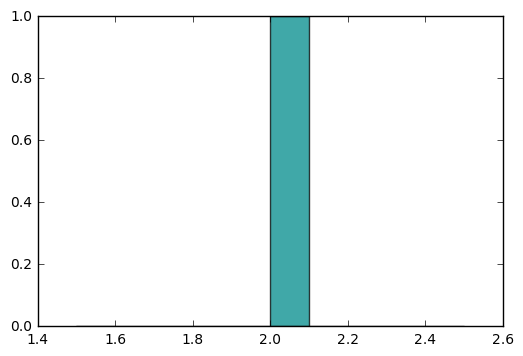

In [77]:
plt.hist(all_n_alleles, color = "darkcyan", alpha = 0.75)
plt.show()

In [78]:
plt.close()

In [79]:
print([i for i in all_n_alleles if i != 2])

[]


Well that's super weird... what is the likelihood of getting exactly two alleles at each snp without filtering for biallelic snps???


<br>
<br>
What about my raw populations output, before filtering for missing data at each locus?

In [82]:
infile = open("../../stacks_b7_wgenome/batch_7_genotypes.txt", "r")
tempfile = open("temp_transposed_genotypes.txt", "w")

header = True
matrix_of_data = []

for line in infile:
    tmp_line = ''

    if header:
        tmp_line = ''
        header = False

    tmp_line += line

    matrix_of_data.append(tmp_line.split())

infile.close()
        
transposed = zip(*matrix_of_data)

for line in transposed:
	tmp_output = str(line).replace('[', '').replace('(', '').replace("'", '').replace(')', '').replace(',', '').replace(']', '') + '\n'
	tempfile.write(tmp_output)

tempfile.close()

In [83]:

infile = open("temp_transposed_genotypes.txt", "r")

infile.readline()
transition = 0
transversion = 0
# 1 - A, 2 - C, 3 - G, 4 - T

for mystring in infile:
    stripped_string = mystring.strip('\n')
    all_genotypes = stripped_string.split(' ')[1:] #subset genotypes only from line
    alleles = []
    all_n_alleles = []
    for genotype in all_genotypes:
        a1 = int(genotype[0:2]) #separate genotype into two alleles
        a2 = int(genotype[2:])
        if a1 not in alleles and a1 != 0: #append allele to list IF it is unique and not 0
            alleles.append(a1)
        if a2 not in alleles and a2 != 0:
            alleles.append(a2)
    if (1 in alleles and 3 in alleles) or (2 in alleles and 4 in alleles):
        transition += 1
    elif (1 in alleles and 2 in alleles) or (3 in alleles and 4 in alleles):
        transversion += 1
    n_alleles = len(alleles) #find total number of alleles at locus 
    all_n_alleles.append(n_alleles) #append that number to list
infile.close()

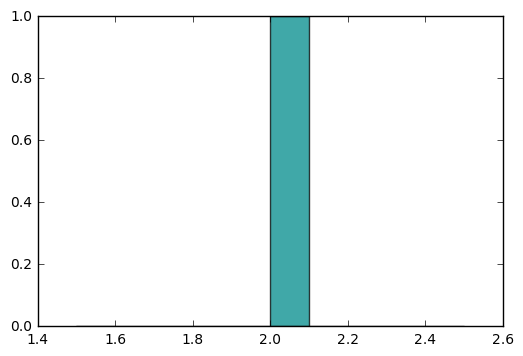

In [84]:
plt.hist(all_n_alleles, color = "darkcyan", alpha = 0.75)
plt.show()

In [85]:
plt.close()

**Understanding why all SNPs are biallelic: see [this notebook]().**

<br>
<br>
#### 8/29/2017
<br>
#### STEP ONE: convert matrix to genepop file

In [1]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [2]:
cd ../scripts/PostStacksFilter_rSNP/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/scripts/PostStacksFilter_rSNP


In [4]:
!python matrix_conversion_forGENEPOP.py -h

usage: matrix_conversion_forGENEPOP.py [-h] [-f INPUT] [-o OUTPUT] [-m POPMAP]
                                       [-pm PATH_POPMAP] [-ps PATH_STACKS]
                                       [-t TITLE]

convert matrix file (samples as column headers) to a genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        2 x 2 matrix file with samples as column headers, one
                        row per locus.
  -o OUTPUT, --output OUTPUT
                        output file in genepop format
  -m POPMAP, --popmap POPMAP
                        population map file
  -pm PATH_POPMAP, --path_popmap PATH_POPMAP
                        path to population map file
  -ps PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including input file
  -t TITLE, --title TITLE
                        title for your genepop file


In [12]:
!python matrix_conversion_forGENEPOP.py \
-f batch_7.filteredLoci60 \
-o batch_7_genepop.txt \
-m PopMap_L1-5_final.txt \
-pm ../ \
-ps ../../stacks_b7_wgenome \
-t "Korean aggregates of Pacific cod, stacks batch 7"

You have 9 populations.
These are your populations, with the number of samples in each:
OrderedDict([('Pohang15', 34), ('Geoje15', 37), ('Namhae15', 19), ('YellowSea16', 30), ('Jukbyeon07', 37), ('JinhaeBay07', 52), ('JinhaeBay08', 56), ('Boryeong07', 24), ('Geoje14', 36)])
creating script for part 2...
calling script for part 2...
transposing genotypes matrix...
writing loci into genepop file...
writing genotypes into genepop file by population...
done.


#### STEP TWO: GENEPOP

Option 5 >> suboption 1

<br>
#### STEP THREE: Parse GENEPOP .INF output

In [13]:
!python parse_INF_file.py -h 

usage: parse_INF_file.py [-h] [-f INPUT] [-p PATH_STACKS] [-pop POPS]
                         [-b BATCH]

parse .INF file from genepop to get allele frequences by population by locus

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        .INF file
  -p PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including .INF file
  -pop POPS, --pops POPS
                        string of population names, in quotation marks
                        (separate each name with a space, not a comma). make
                        sure this is in the same order as the populations
                        listed in the .INF output file! (aka the order of your
                        populations in your pop map file)
  -b BATCH, --batch BATCH
                        stacks batch number


In [14]:
!python parse_INF_file.py \
-f batch_7_genepop.txt.INF \
-p ../../stacks_b7_wgenome \
-pop "POH GEO NAM YS JUK JBE JBL BOR GEO14" \
-b 7

You have a maximum of  2  alleles at one or more of your loci.
9  populations detected.
Heading written to output file. Now parsing allele frequencies...
Done.
Parsed allele frequencies in  20516  loci.


#### STEP FOUR: filter for MAF using parsed file and original matrix

In [15]:
!python filter_for_MAF_from_parsedINF.py -h 

usage: filter_for_MAF_from_parsedINF.py [-h] [-inf INFINPUT]
                                        [-mat MATRIXINPUT] [-og OUTPUT_GOOD]
                                        [-ob OUTPUT_BAD]
                                        [-ofg OUTPUTFREQS_GOOD]
                                        [-ofb OUTPUTFREQS_BAD]
                                        [-p PATH_STACKS] [-a ALLELES]
                                        [-b BATCH]

filter for MAF using parsed .INF genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -inf INFINPUT, --INFinput INFINPUT
                        parsed .INF file
  -mat MATRIXINPUT, --MATRIXinput MATRIXINPUT
                        half filtered matrix file that was used to make
                        genepop file
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file, good loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file, bad loci
  -ofg OUTPUTFREQS_

In [16]:
!python filter_for_MAF_from_parsedINF.py \
-inf batch_7_parseINF.txt \
-mat batch_7.filteredLoci60 \
-og batch_7.filteredLoci60_filteredMAF \
-ob batch_7.filteredLoci60_filteredMAF_badloci \
-ofg batch_7.filteredLoci60_filteredMAF_goodfreqs \
-ofb batch_7.filteredLoci60_filteredMAF_badfreqs \
-p ../../stacks_b7_wgenome \
-a 2 \
-b 7 \

9189  loci written to filtered output file.
Filtered out  11327  loci.


<br>
<br>

### Filter Loci for Missing Data

I'd like to filter more stringently for loci missing data, to a threshold of p = 0.20. 
Since my matrix file has individuals as columns and loci as rows, I'll use a slightly different script than above. 

In [17]:
!python filter_loci_missing_data_postMAF.py -h 

usage: filter_loci_missing_data_postMAF.py [-h] [-f INPUT] [-og OUTPUT_GOOD]
                                           [-ob OUTPUT_BAD]
                                           [-op OUTPUT_PROPORTIONS]
                                           [-s STACKS_PATH] [-p PERCENT]

filter loci for missing data

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        genotype file in 2 x 2 matrix
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file containing 'good' loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file containing 'bad' loci
  -op OUTPUT_PROPORTIONS, --output_proportions OUTPUT_PROPORTIONS
                        output file containing the missing data per locus
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files
  -p PERCENT, --percent PERCENT
                        threshold to rem

In [19]:
!python filter_loci_missing_data_postMAF.py \
-f batch_7.filteredLoci60_filteredMAF \
-og batch_7.filteredLoci60_filteredMAF_Loci2 \
-ob batch_7.filteredLoci60_filteredMAF_Loci2_badloci \
-op batch_7.filteredLoci60_filteredMAF_Loci2_props20 \
-s ../../stacks_b7_wgenome \
-p 0.20

calculating 'good' and 'bad' loci...
writing 'good' and 'bad' loci to files...
done.
Total loci:  9189
Loci retained:  5447
Loci removed:  3742
Missing data info per locus can be found in the 'proportions' output file.


<br>
<br>
### Filter individuals for missing data

In [21]:
!python filter_individs_missing_data.py -h

usage: filter_individs_missing_data.py [-h] [-f INPUT] [-og OUTPUT_GOOD]
                                       [-ob OUTPUT_BAD]
                                       [-op OUTPUT_PROPORTIONS]
                                       [-s STACKS_PATH] [-p PERCENT]

filter individuals for missing data

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        genotype file in 2 x 2 matrix
  -og OUTPUT_GOOD, --output_good OUTPUT_GOOD
                        output file containing 'good' loci
  -ob OUTPUT_BAD, --output_bad OUTPUT_BAD
                        output file containing 'bad' loci
  -op OUTPUT_PROPORTIONS, --output_proportions OUTPUT_PROPORTIONS
                        output file containing the missing data per individual
  -s STACKS_PATH, --stacks_path STACKS_PATH
                        path to the directory containing your stacks files
  -p PERCENT, --percent PERCENT
                        threshold to remove 

In [23]:
!python filter_individs_missing_data.py \
-f batch_7.filteredLoci60_filteredMAF_Loci2 \
-og batch_7.filteredLoci60_filteredMAF_Loci2_filteredIndivids \
-ob batch_7.filteredLoci60_filteredMAF_Loci2_filteredIndivids_bad \
-op batch_7.filteredLoci60_filteredMAF_Loci2_filteredIndivids_props \
-s ../../stacks_b7_wgenome \
-p 0.20

Transposing matrix...
calculating which individuals are missing too much data...
Deleting temporary file...
writing individuals to files...
done.
Total individuals processed:  325
Individuals retained:  299
Individuals removed:  26
Missing data info per individual can be found in the 'proportions' output file.


#### With strictest loci / individual missing data filters:

#### 5,447 loci retained
#### 299 / 325 individuals retained